In [3]:
import os
import random
import json
import warnings 
warnings.filterwarnings('ignore')

import torch
from torch.utils.data import Dataset, DataLoader
from utils import label_accuracy_score, add_hist
import cv2

import numpy as np
import pandas as pd

# 전처리를 위한 라이브러리
from pycocotools.coco import COCO

#!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2

# 시각화를 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

plt.rcParams['axes.grid'] = False
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
batch_size = 16   # Mini-batch size
num_epochs = 20
learning_rate = 0.0001

In [5]:
# seed 고정
random_seed = 2022
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [6]:
%matplotlib inline

dataset_path  = '../data'
anns_file_path = dataset_path + '/' + 'train_all.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 10
Number of categories: 10
Number of annotations: 26240
Number of images: 3272


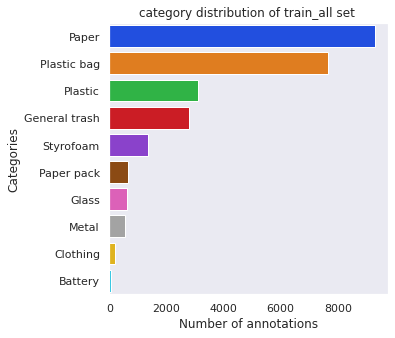

In [7]:
# Count annotations
cat_histogram = np.zeros(nr_cats,dtype=int)
for ann in anns:
    cat_histogram[ann['category_id']-1] += 1

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(5,5))

# Convert to DataFrame
df = pd.DataFrame({'Categories': cat_names, 'Number of annotations': cat_histogram})
df = df.sort_values('Number of annotations', 0, False)

# Plot the histogram
plt.title("category distribution of train_all set ")
palette = sns.set_palette("bright")
plot_1 = sns.barplot(x="Number of annotations", y="Categories", data=df, label="Total")

In [8]:
# category labeling 
sorted_temp_df = df.sort_index()

# background = 0 에 해당되는 label 추가 후 기존들을 모두 label + 1 로 설정
sorted_df = pd.DataFrame(["Backgroud"], columns = ["Categories"])
sorted_df = sorted_df.append(sorted_temp_df, ignore_index=True)

In [9]:
# class (Categories) 에 따른 index 확인 (0~10 : 총 11개)
sorted_df

,Categories,Number of annotations
0,Backgroud,NaN
1,General trash,2782.0
2,Paper,9311.0
3,Paper pack,659.0
4,Metal,562.0
5,Glass,610.0
6,Plastic,3090.0
7,Styrofoam,1343.0
8,Plastic bag,7643.0
9,Battery,63.0


In [92]:
category_names = list(sorted_df.Categories)
category_names.append('all')

def get_classname(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"

class CustomDataLoader(Dataset):
    """COCO format"""
    def __init__(self, data_dir,transform = None):
        super().__init__()
        self.transform = transform
        self.coco = COCO(data_dir)
        
    def __getitem__(self, index: int):
        # dataset이 index되어 list처럼 동작
        image_id = self.coco.getImgIds(imgIds=index)
        image_infos = self.coco.loadImgs(image_id)[0]
        
        # cv2 를 활용하여 image 불러오기
        images = cv2.imread(os.path.join(dataset_path, image_infos['file_name']))
        images = cv2.cvtColor(images, cv2.COLOR_BGR2RGB).astype(np.float32)
        images /= 255.0
        
        ann_ids = self.coco.getAnnIds(imgIds=image_infos['id'])
        anns = self.coco.loadAnns(ann_ids)

        # Load the categories in a variable
        cat_ids = self.coco.getCatIds()
        cats = self.coco.loadCats(cat_ids)

        # masks : size가 (height x width)인 2D
        # 각각의 pixel 값에는 "category id" 할당
        # Background = 0
        masks = np.zeros((image_infos["height"], image_infos["width"]))
        for i in range(11):
            globals()["mask{}".format(i)] = np.zeros((image_infos["height"], image_infos["width"]))
        # General trash = 1, ... , Cigarette = 10
        anns = sorted(anns, key=lambda idx : idx['area'], reverse=True)
        

        for i in range(len(anns)):
            className = get_classname(anns[i]['category_id'], cats)
            pixel_value = category_names.index(className)
            masks[self.coco.annToMask(anns[i]) == 1] = pixel_value
            globals()["mask{}".format(pixel_value)][self.coco.annToMask(anns[i]) == 1] = pixel_value
            mask0[self.coco.annToMask(anns[i]) == 1] = 1
        masks = masks.astype(np.int8)
            
            
        mask_labeled = [mask0, mask1, mask2, mask3, mask4, mask5, mask6, mask7, mask8, mask9, mask10, masks]
                        
        # transform -> albumentations 라이브러리 활용
        if self.transform is not None:
            transformed = self.transform(image=images, mask=masks)
            images = transformed["image"]
            masks = transformed["mask"]
        return images, masks, image_infos, mask_labeled

    
    def __len__(self) -> int:
        # 전체 dataset의 size를 return
        return len(self.coco.getImgIds())

In [93]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

transform = A.Compose([
                            #A.Resize(256, 256),
                            ToTensorV2()
                            ])

all_dataset = CustomDataLoader(data_dir=anns_file_path, transform=transform)

loading annotations into memory...
Done (t=5.78s)
creating index...
index created!


In [94]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,203,29,37
2,Paper,34,80,255
3,Paper pack,139,74,20
4,Metal,128,0,0
5,Glass,220,97,184
6,Plastic,48,179,70
7,Styrofoam,138,66,203
8,Plastic bag,223,125,32
9,Battery,59,200,227


In [95]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for idx, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[idx] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]
    

In [96]:
from ipywidgets import interact



@interact(idx=(0, len(all_dataset)-1), size=(15, 50), cls_id=(0, 11))
def showImg(idx=0, size=25, cls_id=12):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(size, size))
    
    row = -1
    img, mask, image_infos, mask_labeled = all_dataset[idx]
    row += 1
    axes[0].imshow(img.permute([1,2,0]))
    if cls_id == 11:
        axes[1].imshow(label_to_color_image(mask_labeled[cls_id]))
    else:
        axes[1].imshow(mask_labeled[cls_id])
    axes[1].set_title("{}".format(category_names[cls_id]), fontsize=15)
    axes[0].set_title([{int(i),category_names[int(i)]} for i in list(np.unique(mask))], fontsize=30)
    fig.show()

    counts = len(np.unique(mask))
    fig2, axes2 = plt.subplots(nrows=1, ncols=counts, figsize=(size, size))
    for i in range(counts):
        axes2[i].imshow(mask_labeled[list(np.unique(mask))[i]])
        axes2[i].set_title("{}".format(category_names[list(np.unique(mask))[i]]), fontsize=15)
    fig2.show()

interactive(children=(IntSlider(value=0, description='idx', max=3271), IntSlider(value=25, description='size',…